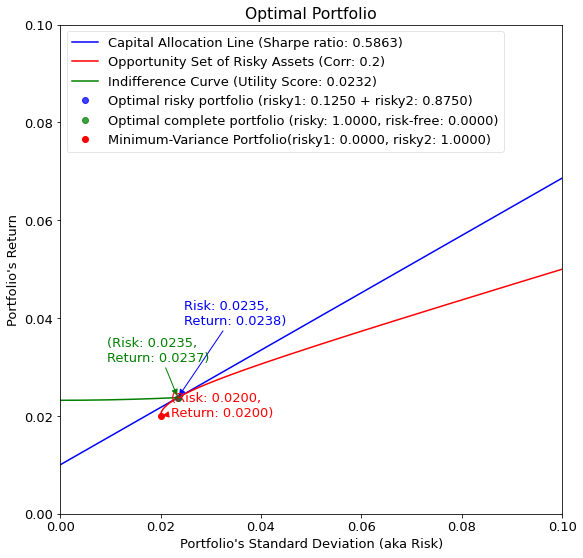

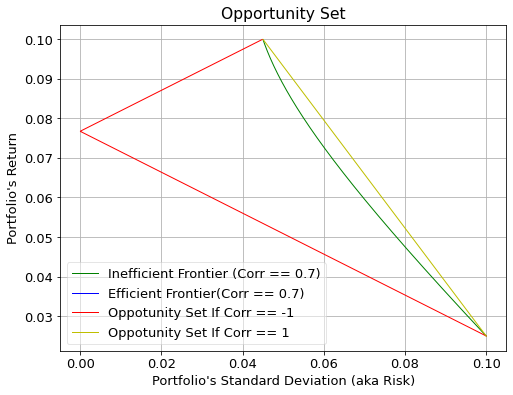

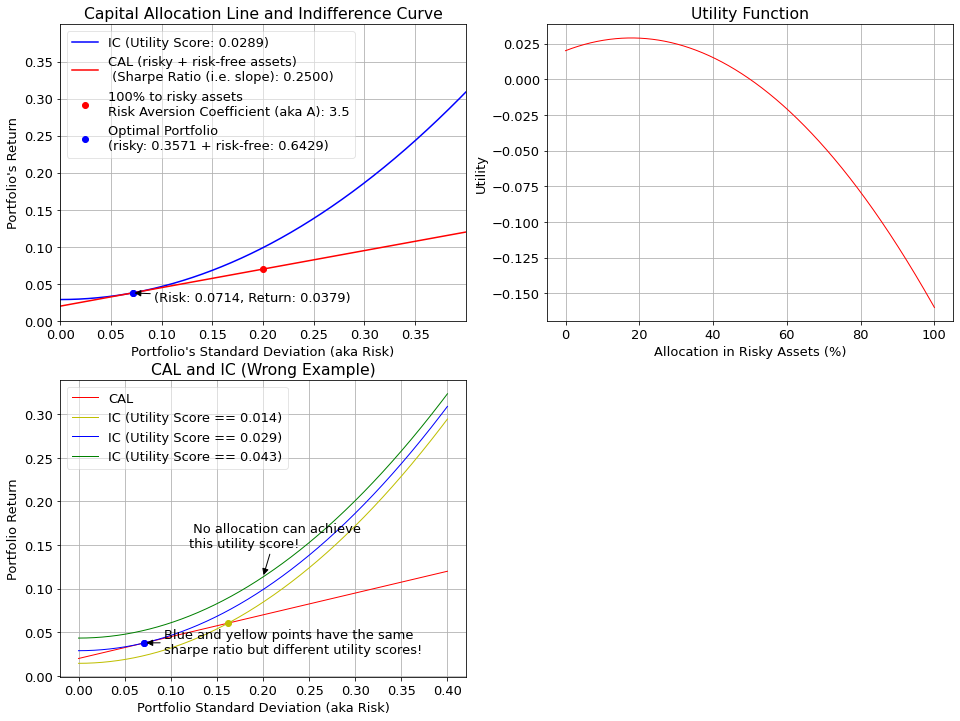

In [9]:
from sympy.solvers import solve
from sympy import Symbol
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import pandas as pd
import statistics as stat


def lec3_get_stddev_of_a_stock_with_index_model(beta: float, market_stddev: float,
                                                firm_specfici_stddev: float) -> float:
    
    return (beta ** 2 * market_stddev ** 2 + firm_specfici_stddev ** 2) ** 0.5

def lec3_get_standard_deviation_aka_σ_of_stock(r_squared: float, beta: float,
                                         market_standard_deviation_aka_σ: float) -> float:
    # this formula is a combination of pages 21 and 22 of lec3_index-models.pdf
    return (1 / r_squared  * beta ** 2 * market_standard_deviation_aka_σ ** 2) ** 0.5


def lec2_plot_optimal_risky_portfolio(expected_return_asset1: float, expected_return_asset2: float,
                         stddev_aka_volatility_asset1: float, stddev_aka_volatility_asset2: float,
                         correlation_aka_ρ: float,
                         risk_free_rate: float,
                         risk_aversion_coefficient: float):

    assert expected_return_asset1 < 0.5 and expected_return_asset2 < 0.5
    assert risk_free_rate < 0.1
#    assert abs(correlation_aka_ρ) > 0.01
    # Note the difference between corr and cov!!!
    # They are closely related but different!
    ρ = correlation_aka_ρ
    A = risk_aversion_coefficient
    upper_bound = 1000000
    port_p_σs = []
    # Definitions of p and c are the same as those on Prof. Benz's slide.
    port_p_sr = -1
    port_p_returns = []
    port_p_w1 = 0
    port_p_σ = 0
    port_p_return = 0

    port_mv_w1 = 0
    port_mv_return = 0
    port_mv_σ = 6666

    for i in range(upper_bound + 1):
        w1 = i / upper_bound
        w2 = 1 - w1
        var, σ = get_portfolio_variance_and_standard_deviation(
                            weights_based_on_market_price = [w1, w2],
                            standard_deviations_aka_volatility = [stddev_aka_volatility_asset1,
                                                                  stddev_aka_volatility_asset2],
                            correlation = ρ)
  #      print(var, σ)
        port_p_σs.append(σ)
        port_p_returns.append(w1 * expected_return_asset1 + w2 * expected_return_asset2)
        if σ!= 0:
            sharpe_ratio = (port_p_returns[i] - risk_free_rate) / σ
        else: # if two assets are perfectly negatively correlated, var and σ will become zero.
            sharpe_ratio = 2147483647
        if sharpe_ratio > port_p_sr:
            port_p_sr = sharpe_ratio
            port_p_w1 = w1
            port_p_σ = σ
            port_p_return = port_p_returns[i]
        if σ < port_mv_σ:
            port_mv_σ = σ
            port_mv_return = port_p_returns[i]
            port_mv_w1 = w1


    port_c_returns = []
    port_c_σs = []
    for i in range(upper_bound + 1):

        port_c_return, port_c_σ = lec2_get_return_and_risk_of_portfolio_with_risk_free_and_risky_assets(
                 percentage_in_risky_assets = (i / upper_bound),
                 percentage_in_risk_free_assets = 1 - (i / upper_bound),
                 risk_free_return = risk_free_rate,
                 expected_return_of_risky_assets = port_p_return,
                 standard_deviation_aka_risk_of_risky_assets = port_p_σ)
        port_c_returns.append(port_c_return)
        port_c_σs.append(port_c_σ)

    utility_scores = lec1_get_utility_score(
           expected_returns = port_c_returns,
           risk_aversion_coefficients = [A] * len(port_c_returns),
           variances_aka_standard_deviations_squared = None,
           standard_deviations_aka_risks = port_c_σs)
    max_util = max(utility_scores)
    returns_for_highest_utility = []
    for i in range(upper_bound + 1):
        returns_for_highest_utility.append(max_util + 0.5 * A * port_c_σs[i] ** 2)

    x = np.array(port_c_σs)
    f = np.array(port_c_returns)
    g = np.array(returns_for_highest_utility)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()

    plt.figure(figsize = (9, 9))
    plt.rcParams.update({'font.size': 13})
   # plt.grid()
    plt.xlim(0, max(port_p_σs))
    y_upper = max(expected_return_asset1, expected_return_asset2) * 2
    plt.ylim([0, y_upper])
    plt.title('Optimal Portfolio')
    plt.xlabel('Portfolio\'s Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio\'s Return')

    plt.plot([0, max(port_p_σs)], [risk_free_rate, max(port_p_σs) * (port_p_sr) + risk_free_rate], 'b', label = 'Capital Allocation Line (Sharpe ratio: {:.4f})'.format(port_p_sr))
    plt.plot(port_p_σs, port_p_returns, color = 'r', label = 'Opportunity Set of Risky Assets (Corr: {})'.format(ρ))
    plt.plot(port_c_σs, returns_for_highest_utility, color = 'g', label = 'Indifference Curve (Utility Score: {})'.format(round(max_util, 4)))

    plt.plot(port_p_σ, port_p_return, 'bo', label = 'Optimal risky portfolio (risky1: {:.4f} + risky2: {:.4f})'.format(port_p_w1, 1 - port_p_w1), alpha = 0.75)
  #  plt.plot([0, port_p_σ], [port_p_return, port_p_return], 'k--', linewidth = 1)
    plt.annotate('Risk: {:.4f},\nReturn: {:.4f})'.format(port_p_σ, port_p_return), xy=(port_p_σ, port_p_return), color = 'blue',
                 xytext=(port_p_σ * 1.05, port_p_return + y_upper * 0.15),
                 arrowprops=dict(color='blue', arrowstyle ='-|>'))

    plt.plot(x[idx], f[idx], 'go', label = 'Optimal complete portfolio (risky: {:.4f}, risk-free: {:.4f})'.format(x[idx][0] / port_p_σ, 1 - x[idx][0] / port_p_σ), alpha = 0.75)
   # plt.plot([x[idx][0], x[idx][0]], [0, f[idx][0]], 'k--', linewidth = 1)
    plt.annotate('(Risk: {:.4f},\nReturn: {:.4f})'.format(x[idx][0], f[idx][0]), xy=(x[idx][0], f[idx][0]), color = 'green',
                 xytext=(x[idx][0] * 0.4, f[idx][0] + y_upper * 0.075),
                 arrowprops=dict(color='green', arrowstyle ='-|>'))

    plt.plot(port_mv_σ, port_mv_return, 'ro', label = 'Minimum-Variance Portfolio(risky1: {:.4f}, risky2: {:.4f})'.format(port_mv_w1, 1 - port_mv_w1))
    plt.annotate('(Risk: {:.4f},\nReturn: {:.4f})'.format(port_mv_σ, port_mv_return), xy=(port_mv_σ, port_mv_return), color = 'red',
                 xytext=(port_mv_σ * 1.1, port_mv_return),
                 arrowprops=dict(color='red', arrowstyle ='-|>'))

    plt.legend(loc = 'upper left', framealpha = 0.5)
    plt.show()

    return port_p_σ, port_p_sr, port_p_return

def plot_opportunity_set(expected_return_asset1: float, expected_return_asset2: float,
                         stddev_aka_volatility_asset1: float, stddev_aka_volatility_asset2: float,
                         correlation_coefficient_aka_ρ: float):

    assert expected_return_asset1 < 0.5 and expected_return_asset2 < 0.5
    upper_bound = 1000
    ρ = correlation_coefficient_aka_ρ
    σ = []
    σ_negative = []
    σ_positive = []
    portfolio_return = []
    for i in range(0, upper_bound):
        w1 = i / upper_bound
        w2 = (upper_bound - i) / upper_bound
        var_t, σ_t = get_portfolio_variance_and_standard_deviation(
                            weights_based_on_market_price = [w1, w2],
                            standard_deviations_aka_volatility = [stddev_aka_volatility_asset1,
                                                                  stddev_aka_volatility_asset2],
                            correlation = ρ)
        var_t, σ_t_negative = get_portfolio_variance_and_standard_deviation(
                            weights_based_on_market_price = [w1, w2],
                            standard_deviations_aka_volatility = [stddev_aka_volatility_asset1,
                                                                  stddev_aka_volatility_asset2],
                            correlation = -1)
        var_t, σ_t_positive = get_portfolio_variance_and_standard_deviation(
                            weights_based_on_market_price = [w1, w2],
                            standard_deviations_aka_volatility = [stddev_aka_volatility_asset1,
                                                                  stddev_aka_volatility_asset2],
                            correlation = 1)

        σ_positive.append(σ_t_positive)
        σ_negative.append(σ_t_negative)
        σ.append(σ_t)
        portfolio_return.append(w1 * expected_return_asset1 + w2 * expected_return_asset2)

    cutoff = σ.index(min(σ))

    plt.figure(figsize = (2 * 4, 2 * 3))
    plt.grid()
    plt.title('Opportunity Set')
    plt.xlabel('Portfolio\'s Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio\'s Return')

    plt.plot(σ[0:cutoff], portfolio_return[0:cutoff], color = 'g', linewidth = 1, label = 'Inefficient Frontier (Corr == {})'.format(ρ))
    plt.plot(σ[cutoff:], portfolio_return[cutoff:], color = 'b', linewidth = 1, label = 'Efficient Frontier(Corr == {})'.format(ρ))
    plt.plot(σ_negative, portfolio_return, color = 'r', linewidth = 1, label = 'Oppotunity Set If Corr == -1')
    plt.plot(σ_positive, portfolio_return, color = 'y', linewidth = 1, label = 'Oppotunity Set If Corr == 1')
    plt.legend(loc = 'best', framealpha = 0.5)
    plt.show()

def _lec2_plotting_cal_and_indifference_curve(
        upper_bound,
        portfolio_std_dev_aka_risks,
        portfolio_expected_returns,
        returns_for_highest_utility,
        returns_for_highest_utility_50percent,
        returns_for_highest_utility_150percent,
        max_util,
        A,
        utility_scores,
        util_50percent,
        util_150percent):

    # Definitions of c is the same as the lecture slides using by Prof. Benz
    port_c_σ = portfolio_std_dev_aka_risks
    port_c_ret = portfolio_expected_returns
    fig = plt.figure(figsize = (4 * 4, 4 * 3))

    fig.add_subplot(2, 2, 1)
    plt.title('Capital Allocation Line and Indifference Curve')
    plt.xlabel('Portfolio\'s Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio\'s Return')
    plt.xlim(0, max(port_c_σ))
    plt.ylim(0, max(port_c_σ))
    plt.grid()

    plt.plot(port_c_σ, returns_for_highest_utility, color = 'b', label = 'IC (Utility Score: {:.4f})'.format(max_util))
    plt.plot(port_c_σ, port_c_ret, color = 'r',
             label = 'CAL (risky + risk-free assets)\n (Sharpe Ratio (i.e. slope): {:.4f})'.format((port_c_ret[int(upper_bound / 2)] - port_c_ret[0]) / port_c_σ[int(upper_bound / 2)]))

    plt.plot(port_c_σ[int(upper_bound / 2)], port_c_ret[int(upper_bound / 2)],'ro',
            label = '100% to risky assets\nRisk Aversion Coefficient (aka A): {}'.format(A))

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'bo', label = 'Optimal Portfolio\n(risky: {:.4f} + risk-free: {:.4f})'.format(port_c_σ.index(x[idx][0])*2/upper_bound, 1 - port_c_σ.index(x[idx][0])*2/upper_bound))
    plt.annotate('(Risk: {:.4f}, Return: {:.4f})'.format(x[idx][0], f[idx][0]),
                 xy=(x[idx][0], f[idx][0]), xytext=(x[idx][0] * 1.3, f[idx][0] * 0.7),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.legend(loc = 'upper left', framealpha = 0.5)

    fig.add_subplot(2, 2, 2)
    plt.title('Utility Function')
    plt.xlabel('Allocation in Risky Assets (%)')
    plt.ylabel('Utility')
    plt.grid()
    upper_bound_x = [x / (upper_bound/100) for x in range(upper_bound)]
    plt.plot((upper_bound_x), utility_scores, color = 'r', linewidth = 1)

    fig.add_subplot(2, 2, 3)
    plt.title('CAL and IC (Wrong Example)')
    plt.xlabel('Portfolio Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio Return')
    plt.grid()
#    plt.plot(portfolio_std_dev_aka_risks, returns_for_highest_utility, color = 'r', linewidth = 1)
    plt.plot(port_c_σ, port_c_ret, color = 'r', linewidth = 1, label = 'CAL')
    plt.plot(port_c_σ,
             returns_for_highest_utility_50percent,
             color = 'y', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(util_50percent, 3)))
    plt.plot(port_c_σ,
             returns_for_highest_utility,
             color = 'b', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(max_util, 3)))
    plt.plot(port_c_σ,
             returns_for_highest_utility_150percent,
             color = 'g', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(util_150percent, 3)))

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility_50percent)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'yo')

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'bo')

    plt.annotate("Blue and yellow points have the same\nsharpe ratio but different utility scores!",
                 xy=(x[idx][0], f[idx][0]),
                 xytext=(x[idx][0] * 1.3, f[idx][0] * 0.7),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.annotate(' No allocation can achieve\nthis utility score!',
                 xy=(port_c_σ[int(upper_bound / 2)], returns_for_highest_utility_150percent[int(upper_bound / 2)]),
                 xytext=(port_c_σ[int(upper_bound / 2)] * 0.6, returns_for_highest_utility_150percent[int(upper_bound / 2)] * 1.3),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.legend(loc = 'best', framealpha = 0.5)
    plt.show()

def lec2_plot_cal_utility_function_and_get_optimal_allocation(
                        risk_free_return: float,
                        expected_return_of_risky_assets: float,
                        variance: float,
                        standard_deviation_aka_risk_of_risky_assets: float,
                        risk_aversion_coefficient: float):

    assert variance is None or standard_deviation_aka_risk_of_risky_assets is None
    A = risk_aversion_coefficient
    if standard_deviation_aka_risk_of_risky_assets is None:
        standard_deviation_aka_risk_of_risky_assets = variance ** 0.5

    portfolio_expected_returns = []
    portfolio_std_dev_aka_risks = []
    returns_for_highest_utility = []
    returns_for_highest_utility_50percent = []
    returns_for_highest_utility_150percent = []

    upper_bound = 200000

    for i in range(upper_bound):

        portfolio_expected_return, portfolio_σ_aka_risk = lec2_get_return_and_risk_of_portfolio_with_risk_free_and_risky_assets(
                 percentage_in_risky_assets = (i / (upper_bound / 2)),
                 percentage_in_risk_free_assets = 1 - (i / (upper_bound / 2)),
                 risk_free_return = risk_free_return,
                 expected_return_of_risky_assets = expected_return_of_risky_assets,
                 standard_deviation_aka_risk_of_risky_assets = standard_deviation_aka_risk_of_risky_assets)
        portfolio_expected_returns.append(portfolio_expected_return)
        portfolio_std_dev_aka_risks.append(portfolio_σ_aka_risk)

    utility_scores = lec1_get_utility_score(
           expected_returns = portfolio_expected_returns,
           risk_aversion_coefficients = [A] * len(portfolio_expected_returns),
           variances_aka_standard_deviations_squared = None,
           standard_deviations_aka_risks = portfolio_std_dev_aka_risks)


    max_util = max(utility_scores)
    util_50percent = max_util * 0.5
    util_150percent = max_util * 1.5

    for i in range(upper_bound):
        returns_for_highest_utility.append(max_util + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)
        returns_for_highest_utility_50percent.append(util_50percent + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)
        returns_for_highest_utility_150percent.append(util_150percent + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)



    optimal_allocation_in_risk_assets = (expected_return_of_risky_assets - risk_free_return) / (A * standard_deviation_aka_risk_of_risky_assets ** 2)

    _lec2_plotting_cal_and_indifference_curve(
            upper_bound = upper_bound,
            portfolio_std_dev_aka_risks = portfolio_std_dev_aka_risks,
            portfolio_expected_returns = portfolio_expected_returns,
            returns_for_highest_utility = returns_for_highest_utility,
            returns_for_highest_utility_50percent = returns_for_highest_utility_50percent,
            returns_for_highest_utility_150percent = returns_for_highest_utility_150percent,
            max_util = max_util,
            A = A,
            utility_scores = utility_scores,
            util_50percent = util_50percent,
            util_150percent = util_150percent)

    return utility_scores, optimal_allocation_in_risk_assets


def lec2_get_return_and_risk_of_portfolio_with_risk_free_and_risky_assets(
                                    percentage_in_risky_assets: float,
                                    percentage_in_risk_free_assets: float,
                                    risk_free_return: float,
                                    expected_return_of_risky_assets: float,
                                    standard_deviation_aka_risk_of_risky_assets: float,
                                    variances_aka_standard_deviations_squared = None):

    assert 1 - (percentage_in_risky_assets + percentage_in_risk_free_assets) < 10 ** -10
    assert risk_free_return < 0.1 and expected_return_of_risky_assets < 0.5
    assert risk_free_return < expected_return_of_risky_assets
    assert variances_aka_standard_deviations_squared == None or standard_deviation_aka_risk_of_risky_assets == None
    assert variances_aka_standard_deviations_squared != None or standard_deviation_aka_risk_of_risky_assets != None
    
    σ_squared = variances_aka_standard_deviations_squared
    σ = standard_deviation_aka_risk_of_risky_assets
    if σ == None:
        σ = σ_squared ** 0.5

    portfolio_expected_return = (1 - percentage_in_risky_assets) * risk_free_return
    portfolio_expected_return += percentage_in_risky_assets * expected_return_of_risky_assets

    
    portfolio_std_dev_aka_risk = percentage_in_risky_assets * σ

    return portfolio_expected_return, portfolio_std_dev_aka_risk

def lec1_get_utility_score(expected_returns: List[float],
                           risk_aversion_coefficients: List[float],
                           variances_aka_standard_deviations_squared: List[float],
                           standard_deviations_aka_risks: List[float]) -> List[float]:

    assert variances_aka_standard_deviations_squared == None or standard_deviations_aka_risks == None
    assert len(expected_returns) == len(risk_aversion_coefficients)

    σ_squared = variances_aka_standard_deviations_squared
    if σ_squared == None:
        σ_squared = []
        for i in range(len(standard_deviations_aka_risks)):
            σ_squared.append(standard_deviations_aka_risks[i] ** 2)

    utility_scores = [0] * len(expected_returns)

    for i in range(len(utility_scores)):
        utility_scores[i] = expected_returns[i] - 0.5 * risk_aversion_coefficients[i] * σ_squared[i]
      #  print(i, utility_scores[i], expected_returns[i], risk_aversion_coefficients[i], σ_squared[i])
    return utility_scores


def get_portfolio_variance_and_standard_deviation(
                        weights_based_on_market_price: List[float],
                        standard_deviations_aka_volatility: List[float],
                        correlation: float) -> Tuple[float, float]:

    assert len(weights_based_on_market_price) == 2
    assert len(standard_deviations_aka_volatility) == 2
    assert sum(weights_based_on_market_price) == 1

    σs = standard_deviations_aka_volatility
    w = weights_based_on_market_price
    
    portfolio_var = w[0] ** 2 * σs[0] ** 2 + w[1] ** 2 * σs[1] ** 2 + 2 * w[0] * w[1] * σs[0] * σs[1] * correlation
    
   # print(portfolio_var, w[0] ** 2 * σs[0] ** 2, w[1] ** 2 * σs[1] ** 2)
    portfolio_σ = portfolio_var ** 0.5
    return portfolio_var, portfolio_σ


def get_pv_from_fv(
        fv: float,
        interest_rate: float,
        number_of_periods: int) -> float:
    """
    Keywords: pv, fv
    """
    assert interest_rate < 0.5
    pv = fv / (1 + interest_rate) ** number_of_periods
    return pv

def main():
    
    lec2_plot_optimal_risky_portfolio(expected_return_asset1=0.05, expected_return_asset2=0.02,
                         stddev_aka_volatility_asset1=0.1, stddev_aka_volatility_asset2=0.02,
                         correlation_aka_ρ=0.2,
                         risk_free_rate=0.01,
                         risk_aversion_coefficient=2)
    
    plot_opportunity_set(expected_return_asset1=0.1, expected_return_asset2=0.025,
                         stddev_aka_volatility_asset1=0.045, stddev_aka_volatility_asset2=0.1,
                         correlation_coefficient_aka_ρ=0.7)
    
    lec2_plot_cal_utility_function_and_get_optimal_allocation(
                        risk_free_return=0.02,
                        expected_return_of_risky_assets=0.07,
                        variance=None,
                        standard_deviation_aka_risk_of_risky_assets=0.2,
                        risk_aversion_coefficient=3.5)

if __name__ == '__main__':
    main()